## Vehicle Detection HOG/ SVC



---
## Import

In [1]:
import os
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import pandas as pd

%matplotlib inline

print("import finished.")

import finished.


## Read images

In [2]:
def showimage(path, image):
    img = mpimg.imread(os.path.join(path, str(image)))
    return img

def bgr2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def csvread(path):
    colNames = ['ImageName', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'class', 'attributes']
    df = pd.read_csv(filepath_or_buffer = path, names = colNames, sep = ',', header = None, engine = 'python')
    image = df['ImageName']
    xmin = df['xmin']
    ymin = df['ymin']
    xmax = df['xmax']
    ymax = df['ymax']
    occluded = df['occluded']
    labels = df['class']
    attributes = df['attributes']
    return image, xmin, ymin, xmax, ymax, occluded, labels, attributes

def labelmap(labels):
    labels_mapping = {label:idx for idx,label in enumerate(np.unique(labels))}
    label = labels.map(labels_mapping)
    print(labels_mapping)
    return label

def imgsep_labelcounter(image, labels, n):
    num = labels[labels == n].size
    img = image[labels == n].tolist()
    return img, num

In [3]:
csv_path = './object-dataset/labels.csv'
image, xmin, ymin, xmax, ymax, occluded, labels, attributes = csvread(csv_path)
label = labelmap(labels)
bike_image, bike_num = imgsep_labelcounter(image, label, 0)
car_image, car_num = imgsep_labelcounter(image, label ,1)
pedestrian_image, pedestrian_num = imgsep_labelcounter(image, label, 2)
trafficLight_image, trafficLight_num = imgsep_labelcounter(image, label, 3)
truck_image, truck_num = imgsep_labelcounter(image, label, 4)

{'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4}


## Random plot images

In [4]:
print("Num of bike image: "+str(bike_num))
print("Num of car image: "+str(car_num))
print("Num of pedestrian image: "+str(pedestrian_num))
print("Num of traffic light image: "+str(trafficLight_num))
print("Num of truck image: "+str(truck_num))

Num of bike image: 1676
Num of car image: 60788
Num of pedestrian image: 9866
Num of traffic light image: 17253
Num of truck image: 3503


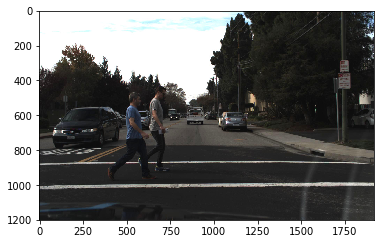

In [5]:
image_path = './object-dataset/'
ind = np.random.randint(0, len(car_image))
image = car_image[ind]
plt.imshow(showimage(image_path, image))

## HOG

Text(0.5,1,'HOG Visualization')

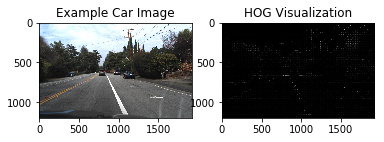

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_image))
# Read in the image
image = showimage(image_path, car_image[ind])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Combine and Normalize Features

In [7]:
from IPython.display import clear_output

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, path, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = showimage(path, file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)   
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        clear_output(wait=True)
        print("remain features: " + str(len(imgs) - len(features)))
    # Return list of feature vectors
    return features

print("Done.")

Done.


In [8]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [ ]:
t = time.time()
bike_features = extract_features(bike_image, image_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG bike features.')
# remain features: 0
# 6185.53 seconds to extract HOG bike features.

In [9]:
import pickle

# Data already saved -> Disable
#print(np.shape(bike_features))
#print(bike_features[0])
#print(type(bike_features))
#dist_pickle = {}
#dist_pickle["features"] = bike_features
#pickle.dump( dist_pickle, open( "bike_features.p", "wb" ) )

with open('./bike_features.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
bike_features_load = dist_pickle["features"]
print(np.shape(bike_features_load))
print(bike_features_load[0])
print(type(bike_features_load))

(1676, 3171)
[1.22000000e+02 1.48000000e+02 1.73000000e+02 ... 2.41788066e-02
 5.37067557e-02 6.13072382e-02]
<class 'list'>


In [ ]:
t = time.time()
pedestrain_features = extract_features(pedestrian_image, image_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG pedestrain features.')
# remain features: 0
# 37249.29 Seconds to extract HOG pedestrain features.

In [10]:
# Data already saved -> Disable
#print(np.shape(pedestrain_features))
#print(pedestrain_features[0])
#print(type(pedestrain_features))
#dist_pickle = {}
#dist_pickle["features"] = pedestrain_features
#pickle.dump( dist_pickle, open( "pedestrain_features.p", "wb" ) )

with open('./pedestrain_features.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
pedestrain_features_load = dist_pickle["features"]
print(np.shape(pedestrain_features_load))
print(pedestrain_features_load[0])
print(type(pedestrain_features_load))

(9866, 3171)
[1.15000000e+02 1.41000000e+02 1.66000000e+02 ... 5.78892499e-02
 4.29994379e-02 5.39975495e-02]
<class 'list'>


In [ ]:
t = time.time()
truck_features = extract_features(truck_image, image_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG truck features.')
# remain features: 0
# 14608.39 Seconds to extract HOG truck features.

In [11]:
# Data already saved -> Disable
#print(np.shape(truck_features))
#print(truck_features[0])
#print(type(truck_features))
#dist_pickle = {}
#dist_pickle["features"] = truck_features
#pickle.dump( dist_pickle, open( "truck_features.p", "wb" ) )

with open('./truck_features.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
truck_features_load = dist_pickle["features"]
print(np.shape(truck_features_load))
print(truck_features_load[0])
print(type(truck_features_load))

(3503, 3171)
[56.         48.         45.         ...  0.24972257  0.27764891
  0.26429528]
<class 'list'>


In [ ]:
t = time.time()
car_features = extract_features(car_image, image_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG car features.')
# remain features: 0
# 254001.82 Seconds to extract HOG car features.

In [12]:
# Data already saved -> Disable
#print(np.shape(car_features))
#print(car_features[0])
#print(type(car_features))
#dist_pickle = {}
#dist_pickle["features"] = car_features
#pickle.dump( dist_pickle, open( "car_features.p", "wb" ) )

with open('./car_features.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
car_features_load = dist_pickle["features"]
print(np.shape(car_features_load))
print(car_features_load[0])
print(type(car_features_load))

(60788, 3171)
[115.         141.         166.         ...   0.28856672   0.28144452
   0.28867001]
<class 'list'>


In [ ]:
t = time.time()
trafficLight_features = extract_features(trafficLight_image, image_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orie, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG traffic light features.')
# remain features: 0
# 68496.17 Seconds to extract HOG traffic light features.

In [13]:
# Data already saved -> Disable
#print(np.shape(trafficLight_features))
#print(trafficLight_features[0])
#print(type(trafficLight_features))
#dist_pickle = {}
#dist_pickle["features"] = trafficLight_features
#pickle.dump( dist_pickle, open( "trafficLight_features.p", "wb" ) )

with open('./trafficLight_features.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
trafficLight_features_load = dist_pickle["features"]
print(np.shape(trafficLight_features_load))
print(trafficLight_features_load[0])
print(type(trafficLight_features_load))

(17253, 3171)
[1.71000000e+02 2.11000000e+02 2.47000000e+02 ... 3.73481802e-02
 3.63876194e-02 2.91729792e-02]
<class 'list'>


In [14]:
# Create an array stack of feature vectors
X = np.vstack((car_features_load, bike_features_load, pedestrain_features_load, 
               truck_features_load, trafficLight_features_load)).astype(np.float64)

# Define the labels vector
# {'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4}
y = np.hstack((np.zeros(len(bike_features_load)), np.ones(len(car_features_load)), 
               np.full(len(pedestrain_features_load), 2), np.full(len(truck_features_load), 4), 
               np.full(len(trafficLight_features_load), 3)))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3171
2258.85 Seconds to train SVC...
Test Accuracy of SVC =  0.872
My SVC predicts:  [1. 1. 1. 3. 1. 1. 1. 1. 3. 3.]
For these 10 labels:  [1. 1. 1. 3. 1. 1. 1. 1. 2. 3.]
0.00148 Seconds to predict 10 labels with SVC


In [15]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

print('Done.')

Done.


In [16]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('Done.')

Done.


In [17]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (32, 32))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

print('Done.')

Done.


In [18]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    """
    Define a function to extract features from a single image window
    Returns: image features and optional hog image
    """
    # Create a list to append feature vectors to
    img_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate([hog_features])        
        else:
            if vis:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features)
    # Return list of feature vectors
    if vis:
        return np.concatenate(img_features), hog_image
    return np.concatenate(img_features)

print('Done.')

Done.


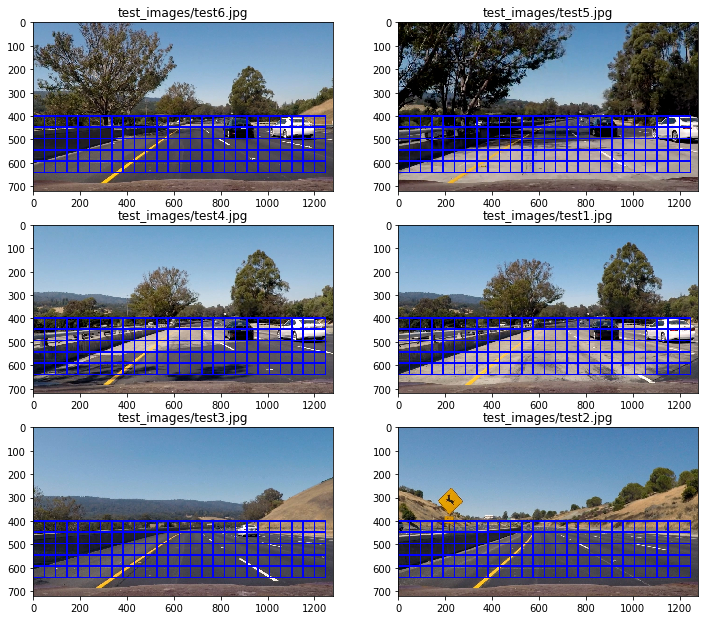

In [19]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

test_images = glob.glob('test_images/*')
y_start_stop = [400, 656]
images = []
titles = []

for file in test_images:
    img = mpimg.imread(file)
    draw_img = np.copy(img)
    # Scale since we have extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = img.astype(np.float32)/255
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    window_img = draw_boxes(draw_img, hot_windows)
    images.append(window_img)
    titles.append(file)

fig = plt.figure(figsize=(12, 18))
for i, img in enumerate(images):
        plt.subplot(5, 2, i + 1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])

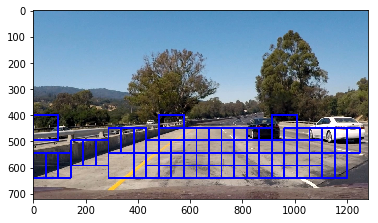

In [20]:
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [400, 656]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [70]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    Define a single function that can extract features using hog sub-sampling and make predictions
    Returns: heatmap image
    """
    bbox_list = []
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, heatmap, bbox_list

print("Done.")

Done.


In [71]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

print("Done.")

Done.


In [72]:
ystart = 400
ystop  = 656
scales = [1.5, 2.0, 2.5]

images = []
titles = []

for img_name in test_images:
    img = mpimg.imread(img_name)
    draw_img = np.copy(img)
    all_recs = []
    # Scale since we have extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = img.astype(np.float32)/255
    for scale in scales:
        _, _, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        all_recs.append(bbox_list)

    rectangles = [bounds for bbox_list in all_recs for bounds in bbox_list]
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, rectangles)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    images.append(draw_img)
    titles.append(img_name)
    images.append(heatmap)
    titles.append(img_name+' Heatmap')

fig = plt.figure(figsize=(12, 30))
visualize(fig, 8, 2, images, titles)

ValueError: operands could not be broadcast together with shapes (1,8364) (3171,) (1,8364) 